In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("TransLogix_Activity3").getOrCreate()

# Prevent Spark from crashing on malformed timestamp strings
spark.conf.set("spark.sql.ansi.enabled", "false")

spark


# load data spark

In [3]:
# Load CSV using Spark
sdf = spark.read.csv(
    "shipments(in).csv",
    header=True,
    inferSchema=True
)

# Preview data and schema
sdf.printSchema()
sdf.show(5)


root
 |-- shipment_id: string (nullable = true)
 |-- origin_hub: string (nullable = true)
 |-- destination_hub: string (nullable = true)
 |-- route_id: string (nullable = true)
 |-- scheduled_departure: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- product_weight_kg: double (nullable = true)
 |-- fragile: string (nullable = true)
 |-- transport_mode: string (nullable = true)
 |-- vehicle_id: string (nullable = true)
 |-- vehicle_reliability: double (nullable = true)
 |-- planned_transit_hours: double (nullable = true)
 |-- scheduled_arrival: string (nullable = true)
 |-- origin_congestion_idx: double (nullable = true)
 |-- dest_congestion_idx: double (nullable = true)
 |-- actual_departure: string (nullable = true)
 |-- actual_arrival: string (nullable = true)
 |-- delay_minutes: integer (nullable = true)
 |-- origin_hub_name: string (nullable = true)
 |-- destination_hub_name: string (nullable = true)
 |-- origin_country: string (nullable = true)
 |-- destin

# **spark data cleaning ddup missing target**

In [4]:
# Remove duplicate records
sdf_clean = sdf.dropDuplicates()

# Remove rows where delay_minutes (target) is missing
sdf_clean = sdf_clean.dropna(subset=["delay_minutes"])

# Check row counts
print("Original rows:", sdf.count())
print("After cleaning:", sdf_clean.count())


Original rows: 100000
After cleaning: 99607


In [5]:
# Parse scheduled_departure (string) -> timestamp safely
sdf_clean = sdf_clean.withColumn(
    "scheduled_departure_ts",
    F.coalesce(
        F.to_timestamp("scheduled_departure", "M/d/yyyy H:mm"),
        F.to_timestamp("scheduled_departure", "MM/dd/yyyy H:mm"),
        F.to_timestamp("scheduled_departure", "yyyy-MM-dd HH:mm:ss")
    )
)

sdf_clean = sdf_clean.filter(F.col("scheduled_departure_ts").isNotNull())

# Time-based derived features
sdf_clean = (
    sdf_clean
    .withColumn("departure_hour", F.hour("scheduled_departure_ts"))
    .withColumn("departure_weekday", F.dayofweek("scheduled_departure_ts"))  # 1=Sun ... 7=Sat
    .withColumn("is_weekend", F.col("departure_weekday").isin([1, 7]))
)

# Proof preview
sdf_clean.select(
    "scheduled_departure",
    "scheduled_departure_ts",
    "departure_hour",
    "departure_weekday",
    "is_weekend"
).show(5, truncate=False)


+-------------------+----------------------+--------------+-----------------+----------+
|scheduled_departure|scheduled_departure_ts|departure_hour|departure_weekday|is_weekend|
+-------------------+----------------------+--------------+-----------------+----------+
|2/22/2024 19:15    |2024-02-22 19:15:00   |19            |5                |false     |
|5/9/2024 21:15     |2024-05-09 21:15:00   |21            |5                |false     |
|5/22/2024 6:15     |2024-05-22 06:15:00   |6             |4                |false     |
|11/1/2024 14:00    |2024-11-01 14:00:00   |14            |6                |false     |
|12/17/2024 6:00    |2024-12-17 06:00:00   |6             |3                |false     |
+-------------------+----------------------+--------------+-----------------+----------+
only showing top 5 rows


**agregation 1 : average delay by orgin hub**

In [6]:
hub_delay = (
    sdf_clean.groupBy("origin_hub_name")
    .agg(
        F.avg("delay_minutes").alias("avg_delay_minutes"),
        F.count("*").alias("shipments")
    )
    .orderBy(F.col("avg_delay_minutes").desc())
)

hub_delay.show(10, truncate=False)


+-----------------------+------------------+---------+
|origin_hub_name        |avg_delay_minutes |shipments|
+-----------------------+------------------+---------+
|Dubai Central Hub      |42.86987411691717 |49967    |
|Jeddah Distribution Hub|41.48525620367386 |24824    |
|Riyadh Logistics Hub   |24.841392649903288|24816    |
+-----------------------+------------------+---------+



**aggrg 2 : avg delay by route**

In [7]:
route_delay = (
    sdf_clean.groupBy("route_name")
    .agg(
        F.avg("delay_minutes").alias("avg_delay_minutes"),
        F.count("*").alias("shipments")
    )
    .orderBy(F.col("avg_delay_minutes").desc())
)

route_delay.show(10, truncate=False)


+-----------------------------------------------+------------------+---------+
|route_name                                     |avg_delay_minutes |shipments|
+-----------------------------------------------+------------------+---------+
|Dubai Central Hub -> Riyadh Logistics Hub      |43.37754856317226 |24916    |
|Dubai Central Hub -> Bahrain Regional Hub      |42.364935531515705|25051    |
|Jeddah Distribution Hub -> Dubai Central Hub   |41.48525620367386 |24824    |
|Riyadh Logistics Hub -> Jeddah Distribution Hub|24.841392649903288|24816    |
+-----------------------------------------------+------------------+---------+



**aggreg 3: avg delay by departure hour**

In [8]:
hour_delay = (
    sdf_clean.groupBy("departure_hour")
    .agg(
        F.avg("delay_minutes").alias("avg_delay_minutes"),
        F.count("*").alias("shipments")
    )
    .orderBy("departure_hour")
)

hour_delay.show(24)


+--------------+------------------+---------+
|departure_hour| avg_delay_minutes|shipments|
+--------------+------------------+---------+
|             0| 30.94214876033058|     1210|
|             1|29.160169491525423|     1180|
|             2|29.987057808455564|     1159|
|             3|30.405907172995782|     1185|
|             4|31.337651122625214|     1158|
|             5|31.800574476815758|     2437|
|             6|  36.8675442204854|     4862|
|             7|41.072473949186275|     8541|
|             8| 43.12357925191155|     9678|
|             9|40.052594670406734|     7130|
|            10|36.864291598023065|     4856|
|            11|35.638074156059766|     3614|
|            12| 34.34029112881077|     3641|
|            13|34.906843013225995|     3478|
|            14| 36.64918367346939|     4900|
|            15|40.279118720179625|     7126|
|            16|  42.9852258336851|     9476|
|            17| 40.70149790293589|     8345|
|            18|36.981735159817354

**spark result to pandas for the charts**

In [9]:
# Convert Spark DataFrames to pandas for visualization
hub_delay_pd = hub_delay.toPandas()
route_delay_pd = route_delay.toPandas()
hour_delay_pd = hour_delay.toPandas()

hub_delay_pd.head()


,origin_hub_name,avg_delay_minutes,shipments
0,Dubai Central Hub,42.869874,49967
1,Jeddah Distribution Hub,41.485256,24824
2,Riyadh Logistics Hub,24.841393,24816


# **Visulaization**

In [10]:
import os
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)


**Visualization 1: Average delay by Origin Hub**

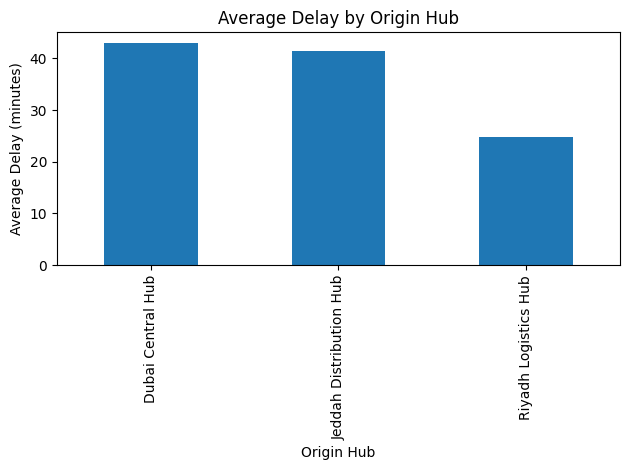

In [11]:
top_hubs = hub_delay_pd.head(5).set_index("origin_hub_name")

plt.figure()
top_hubs["avg_delay_minutes"].plot(kind="bar")
plt.title("Average Delay by Origin Hub")
plt.xlabel("Origin Hub")
plt.ylabel("Average Delay (minutes)")
plt.tight_layout()
plt.savefig("figures/viz1_avg_delay_by_origin_hub.png", dpi=200)
plt.show()


**Visualization 2: Average delay by Route**

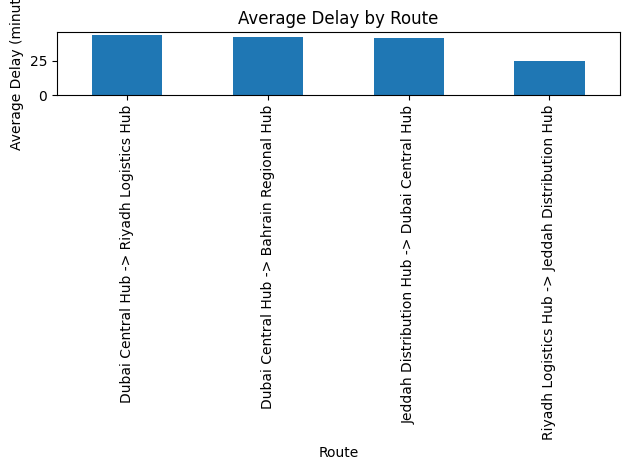

In [12]:
top_routes = route_delay_pd.head(5).set_index("route_name")

plt.figure()
top_routes["avg_delay_minutes"].plot(kind="bar")
plt.title("Average Delay by Route")
plt.xlabel("Route")
plt.ylabel("Average Delay (minutes)")
plt.tight_layout()
plt.savefig("figures/viz2_avg_delay_by_route.png", dpi=200)
plt.show()


**Visualization 3: Avg delay by Departure Hour**

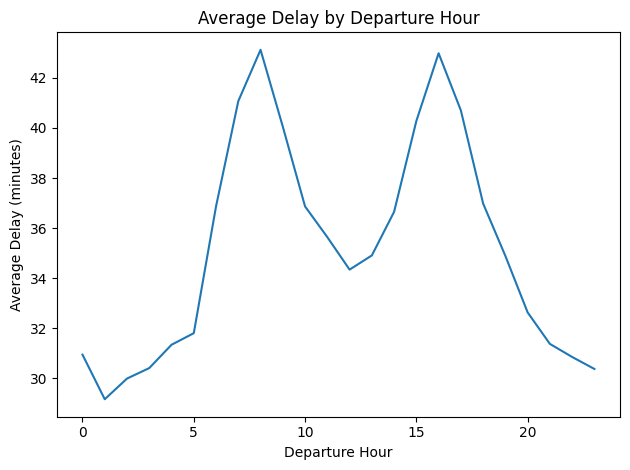

In [13]:
plt.figure()
plt.plot(hour_delay_pd["departure_hour"], hour_delay_pd["avg_delay_minutes"])
plt.title("Average Delay by Departure Hour")
plt.xlabel("Departure Hour")
plt.ylabel("Average Delay (minutes)")
plt.tight_layout()
plt.savefig("figures/viz3_avg_delay_by_hour.png", dpi=200)
plt.show()


**Vis 4: distribuition of delays**

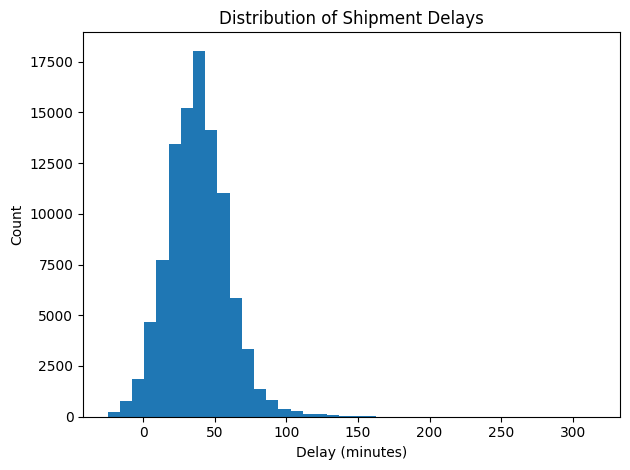

In [14]:
# Convert full cleaned Spark data to pandas for this chart
df_pd = sdf_clean.select("delay_minutes").toPandas()

plt.figure()
plt.hist(df_pd["delay_minutes"], bins=40)
plt.title("Distribution of Shipment Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/viz4_delay_distribution.png", dpi=200)
plt.show()


**Visulaization 5 cngestion VS delay**

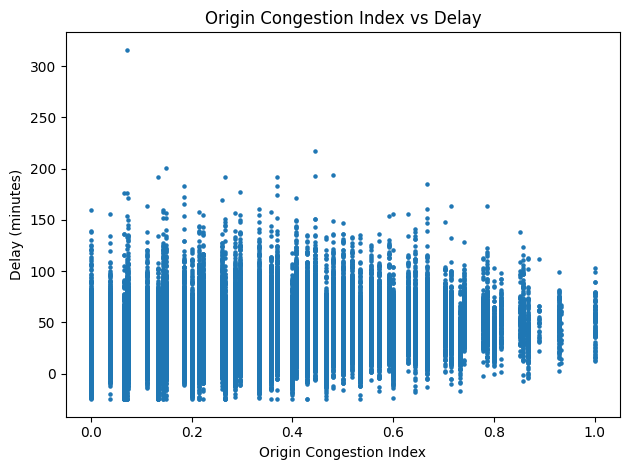

In [15]:
df_pd_full = sdf_clean.select("origin_congestion_idx", "delay_minutes").toPandas()

plt.figure()
plt.scatter(df_pd_full["origin_congestion_idx"], df_pd_full["delay_minutes"], s=5)
plt.title("Origin Congestion Index vs Delay")
plt.xlabel("Origin Congestion Index")
plt.ylabel("Delay (minutes)")
plt.tight_layout()
plt.savefig("figures/viz5_congestion_vs_delay.png", dpi=200)
plt.show()


**visula 6 delays by weekend and wekday**

In [16]:
weekend_delay = (
    sdf_clean.groupBy("is_weekend")
    .agg(
        F.avg("delay_minutes").alias("avg_delay_minutes"),
        F.count("*").alias("shipments")
    )
    .orderBy("is_weekend")
)

weekend_delay_pd = weekend_delay.toPandas()
weekend_delay_pd


,is_weekend,avg_delay_minutes,shipments
0,False,38.170488,71219
1,True,37.688777,28388


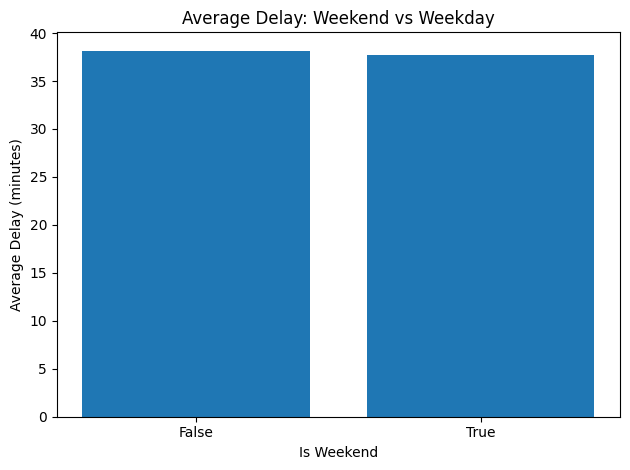

In [17]:
plt.figure()
plt.bar(weekend_delay_pd["is_weekend"].astype(str), weekend_delay_pd["avg_delay_minutes"])
plt.title("Average Delay: Weekend vs Weekday")
plt.xlabel("Is Weekend")
plt.ylabel("Average Delay (minutes)")
plt.tight_layout()
plt.savefig("figures/viz6_weekend_vs_weekday_delay.png", dpi=200)
plt.show()


# **3 Models**

**convert dpart dataset to pandas**

In [18]:
# Convert Spark DataFrame to pandas for modeling
model_df = sdf_clean.select(
    "delay_minutes",
    "distance_km",
    "product_weight_kg",
    "vehicle_reliability",
    "planned_transit_hours",
    "origin_congestion_idx",
    "dest_congestion_idx",
    "departure_hour",
    "is_weekend",
    "transport_mode",
    "fragile",
    "origin_hub_name",
    "destination_hub_name",
    "route_name"
).toPandas()

model_df.head()


,delay_minutes,distance_km,product_weight_kg,vehicle_reliability,planned_transit_hours,origin_congestion_idx,dest_congestion_idx,departure_hour,is_weekend,transport_mode,fragile,origin_hub_name,destination_hub_name,route_name
0,51,482.901405,1625.2,0.980000,17.185,0.148148,0.133333,19,False,SEA,No,Dubai Central Hub,Bahrain Regional Hub,Dubai Central Hub -> Bahrain Regional Hub
1,49,482.901405,1276.7,0.873448,14.096,0.111111,0.333333,21,False,SEA,No,Dubai Central Hub,Bahrain Regional Hub,Dubai Central Hub -> Bahrain Regional Hub
2,39,482.901405,3054.1,0.873448,13.561,0.148148,0.200000,6,False,SEA,No,Dubai Central Hub,Bahrain Regional Hub,Dubai Central Hub -> Bahrain Regional Hub
3,68,482.901405,2277.1,0.907889,15.654,0.148148,0.066667,14,False,SEA,No,Dubai Central Hub,Bahrain Regional Hub,Dubai Central Hub -> Bahrain Regional Hub
4,54,482.901405,1425.5,0.756344,14.287,0.296296,0.200000,6,False,SEA,No,Dubai Central Hub,Bahrain Regional Hub,Dubai Central Hub -> Bahrain Regional Hub


**define features and target**

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Target
y = model_df["delay_minutes"]

# Features
X = model_df.drop(columns=["delay_minutes"])

# Identify column types
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

cat_cols, num_cols


(['is_weekend',
  'transport_mode',
  'fragile',
  'origin_hub_name',
  'destination_hub_name',
  'route_name'],
 ['distance_km',
  'product_weight_kg',
  'vehicle_reliability',
  'planned_transit_hours',
  'origin_congestion_idx',
  'dest_congestion_idx'])

**Preprocessing pipeline (imputation + encoding)**

In [20]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


Train / test **split** **bold text**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((79685, 13), (19922, 13))

**linear regression**

In [22]:
from sklearn.linear_model import LinearRegression

lr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

lr_r2, lr_rmse


(0.2744042240495833, np.float64(17.847997013280626))

**decision tree**

In [23]:
from sklearn.tree import DecisionTreeRegressor

dt_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeRegressor(max_depth=10, random_state=42))
])

dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_r2 = r2_score(y_test, dt_pred)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))

dt_r2, dt_rmse


(0.22810150839327248, np.float64(18.408661324869602))

**random forest**

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

rf_r2, rf_rmse


(0.2178310277081612, np.float64(18.530724685031196))

**Compare models**

In [25]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "R2": [lr_r2, dt_r2, rf_r2],
    "RMSE": [lr_rmse, dt_rmse, rf_rmse]
}).sort_values(by="RMSE")

results


,Model,R2,RMSE
0,Linear Regression,0.274404,17.847997
1,Decision Tree,0.228102,18.408661
2,Random Forest,0.217831,18.530725


**Select preferred model + save outputs**

In [26]:
best_model = results.iloc[0]["Model"]
print("Preferred model (lowest RMSE):", best_model)

results.to_csv("model_results.csv", index=False)

# Save predictions of the best model
if best_model == "Linear Regression":
    best_pred = lr_pred
elif best_model == "Decision Tree":
    best_pred = dt_pred
else:
    best_pred = rf_pred

pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": best_pred
}).to_csv("best_model_predictions.csv", index=False)

print("Saved model_results.csv and best_model_predictions.csv")


Preferred model (lowest RMSE): Linear Regression
Saved model_results.csv and best_model_predictions.csv
